# Binary Classification Deep Learning Model for Chronic Kidney Disease Using Keras
### David Lowe
### November 11, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The problem is to predict the chronic kidney disease from the dataset that was collected from the hospital records for two months.

ANALYSIS: The baseline performance of the model achieved an average accuracy score of 100%. After tuning the hyperparameters, the best model processed the training dataset with an accuracy of 100%. Furthermore, the final model processed the test dataset with an accuracy of 100%, which was consistent with the result obtained from model training.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities

Dataset Used: Chronic Kidney Disease Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

One potential source of performance benchmark: https://www.kaggle.com/mansoordaku/ckdisease

Any deep-learning modeling project genrally can be broken down into about six major tasks:
0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Create the random seed numbers for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
import keras as K
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_kernel_init = K.initializers.RandomNormal(seed=seedNum)
default_loss = 'binary_crossentropy'
default_optimizer = 'adam'
default_epochs = 100
default_batches = 8
default_metrics = ['accuracy']

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [7]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [8]:
dataset_path = 'https://raw.githubusercontent.com/daines-analytics/datasets-public/master/chronic-kidney-disease/chronic_kidney_disease.arff'
colNames = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot',
            'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows= 29, na_values=['?'], skipinitialspace=True)

# Take a peek at the dataframe after import
Xy_original.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [9]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       397 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


In [10]:
Xy_original.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [11]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         3
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64
Total number of NaN in the dataframe:  1013


## 1.b) Data Cleaning

In [12]:
# Impute missing values
Xy_original['age'].fillna(value=Xy_original['age'].median(), inplace=True)
Xy_original['bp'].fillna(value=Xy_original['bp'].median(), inplace=True)
Xy_original['sg'].fillna(1.015, inplace=True)
Xy_original['sg'] = Xy_original['sg'].astype('category')
Xy_original['al'].fillna(2.5, inplace=True)
Xy_original['al'] = Xy_original['al'].astype('category')
Xy_original['su'].fillna(2.5, inplace=True)
Xy_original['su'] = Xy_original['su'].astype('category')
Xy_original['rbc'].fillna('unknown', inplace=True)
Xy_original['rbc'] = Xy_original['rbc'].astype('category')
Xy_original['pc'].fillna('unknown', inplace=True)
Xy_original['pc'] = Xy_original['pc'].astype('category')
Xy_original['pcc'].fillna('unknown', inplace=True)
Xy_original['pcc'] = Xy_original['pcc'].astype('category')
Xy_original['ba'].fillna('unknown', inplace=True)
Xy_original['ba'] = Xy_original['ba'].astype('category')
Xy_original['bgr'].fillna(value=Xy_original['bgr'].median(), inplace=True)
Xy_original['bu'].fillna(value=Xy_original['bu'].median(), inplace=True)
Xy_original['sc'].fillna(value=Xy_original['sc'].median(), inplace=True)
Xy_original['sod'].fillna(value=Xy_original['sod'].median(), inplace=True)
Xy_original['pot'].fillna(value=Xy_original['pot'].median(), inplace=True)
Xy_original['hemo'].fillna(value=Xy_original['hemo'].median(), inplace=True)
Xy_original['pcv'].fillna(value=Xy_original['pcv'].median(), inplace=True)
Xy_original['wbcc'].fillna(value=Xy_original['wbcc'].median(), inplace=True)
Xy_original['rbcc'].fillna(value=Xy_original['rbcc'].median(), inplace=True)
Xy_original['htn'].fillna('unknown', inplace=True)
Xy_original['htn'] = Xy_original['htn'].astype('category')
Xy_original['dm'].fillna('unknown', inplace=True)
Xy_original['dm'] = Xy_original['dm'].astype('category')
Xy_original['cad'].fillna('unknown', inplace=True)
Xy_original['cad'] = Xy_original['cad'].astype('category')
Xy_original['appet'].fillna('unknown', inplace=True)
Xy_original['appet'] = Xy_original['appet'].astype('category')
Xy_original['pe'].fillna('unknown', inplace=True)
Xy_original['pe'] = Xy_original['pe'].astype('category')
Xy_original['ane'].fillna('unknown', inplace=True)
Xy_original['ane'] = Xy_original['ane'].astype('category')

# Convert the class feature with ckd/notckd levels into categorical feature of 0/1
def reClassSomecol(target):
    if (target == 'ckd'): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['class'].apply(reClassSomecol)
Xy_original.drop(columns=['class'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,targetVar
0,48.0,80.0,1.020,1.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,38.0,6000.0,4.8,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,4.8,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1
5,60.0,90.0,1.015,3.0,0.0,unknown,unknown,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,1
6,68.0,70.0,1.010,0.0,0.0,unknown,normal,notpresent,notpresent,100.0,...,36.0,8000.0,4.8,no,no,no,good,no,no,1
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,1
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1


In [13]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age          400 non-null float64
bp           400 non-null float64
sg           400 non-null category
al           400 non-null category
su           400 non-null category
rbc          400 non-null category
pc           400 non-null category
pcc          400 non-null category
ba           400 non-null category
bgr          400 non-null float64
bu           400 non-null float64
sc           400 non-null float64
sod          400 non-null float64
pot          400 non-null float64
hemo         400 non-null float64
pcv          400 non-null float64
wbcc         400 non-null float64
rbcc         400 non-null float64
htn          400 non-null category
dm           400 non-null category
cad          400 non-null category
appet        400 non-null category
pe           400 non-null category
ane          400 non-null category
targetVar    400 non-null int64
dtypes: category(13), float64(11),

In [14]:
Xy_original.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,targetVar
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.737750,0.625000
std,16.982996,13.489785,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.841439,0.484729
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000,0.000000
25%,42.000000,70.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000,0.000000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.800000,1.000000
75%,64.000000,80.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000,1.000000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000,1.000000


In [15]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

age          0
bp           0
sg           0
al           0
su           0
rbc          0
pc           0
pcc          0
ba           0
bgr          0
bu           0
sc           0
sod          0
pot          0
hemo         0
pcv          0
wbcc         0
rbcc         0
htn          0
dm           0
cad          0
appet        0
pe           0
ane          0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (400, 25) X_original.shape: (400, 24) y_original.shape: (400,)


In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

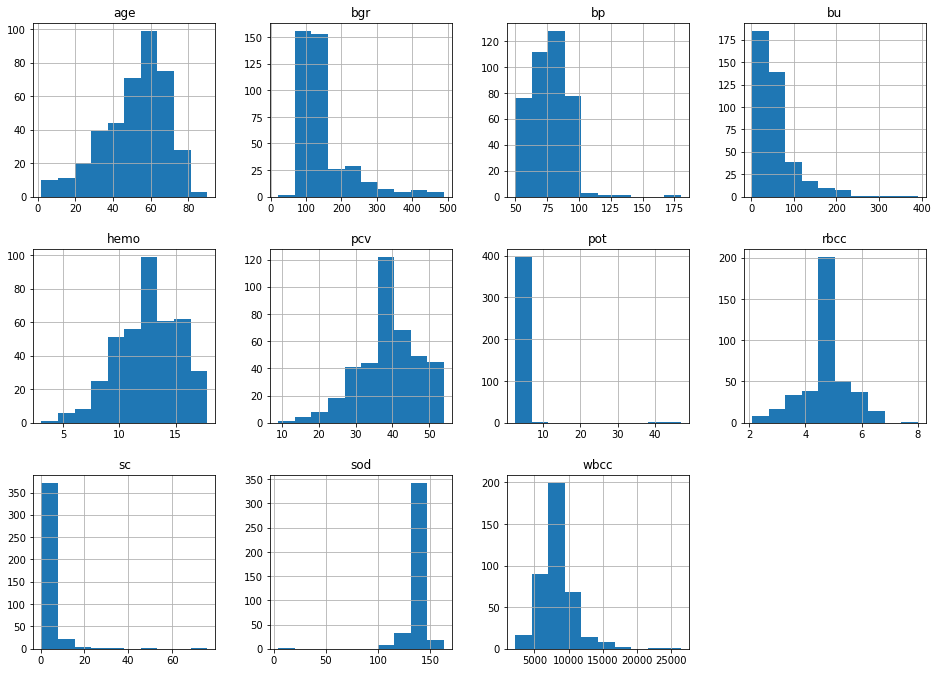

In [19]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [20]:
# Apply feature scaling techniques
X_original['age'] = preprocessing.scale(X_original['age'])
X_original['bp'] = preprocessing.scale(X_original['bp'])
X_original['bgr'] = preprocessing.scale(X_original['bgr'])
X_original['bu'] = preprocessing.scale(X_original['bu'])
X_original['sc'] = preprocessing.scale(X_original['sc'])
X_original['sod'] = preprocessing.scale(X_original['sod'])
X_original['pot'] = preprocessing.scale(X_original['pot'])
X_original['hemo'] = preprocessing.scale(X_original['hemo'])
X_original['pcv'] = preprocessing.scale(X_original['pcv'])
X_original['wbcc'] = preprocessing.scale(X_original['wbcc'])
X_original['rbcc'] = preprocessing.scale(X_original['rbcc'])

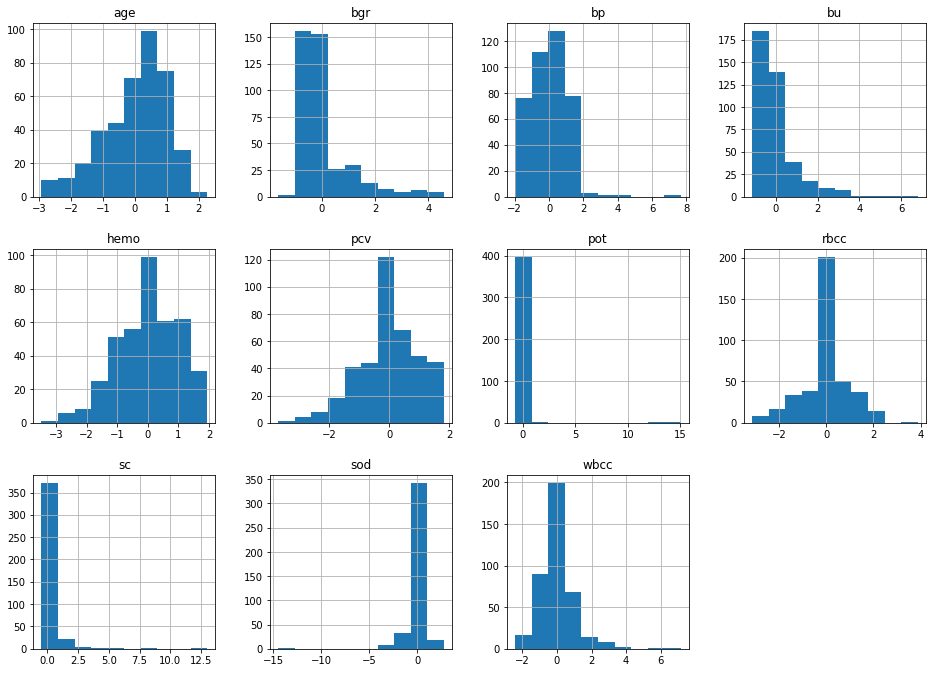

In [21]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [22]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 62 columns):
age               400 non-null float64
bp                400 non-null float64
bgr               400 non-null float64
bu                400 non-null float64
sc                400 non-null float64
sod               400 non-null float64
pot               400 non-null float64
hemo              400 non-null float64
pcv               400 non-null float64
wbcc              400 non-null float64
rbcc              400 non-null float64
sg_1.005          400 non-null uint8
sg_1.01           400 non-null uint8
sg_1.015          400 non-null uint8
sg_1.02           400 non-null uint8
sg_1.025          400 non-null uint8
al_0.0            400 non-null uint8
al_1.0            400 non-null uint8
al_2.0            400 non-null uint8
al_2.5            400 non-null uint8
al_3.0            400 non-null uint8
al_4.0            400 non-null uint8
al_5.0            400 non-null uint8
su_0.0            400 

## 1.d) Splitting Data into Training and Test Sets

In [23]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_original)
y_encoded = encoder.transform(y_original)
print(y_encoded)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
# Split the data further into training and test datasets
X_encoded = X_original.values
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, 
                                                        stratify=y_encoded, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (300, 62) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (300,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (100, 62) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (100,) y_test.type: <class 'numpy.ndarray'>


In [25]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [26]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = K.models.Sequential()
    default_model.add(Dense(31, input_dim=62, kernel_initializer=default_kernel_init, activation='relu'))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init, activation='sigmoid'))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [28]:
# Initialize the Keras model
cv_model = KerasClassifier(build_fn=create_default_model, epochs=default_epochs, batch_size=default_batches, verbose=0)

In [29]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [30]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
startTimeModule = datetime.now()

# Fit and evaluate the Keras model using 10-fold cross validation
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold)
print('Generating results using the metrics of', default_metrics)
print('All cross-Validate results:', results)
print('Baseline results [mean (std)]: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Generating results using the metrics of ['accuracy']
All cross-Validate results: [1. 1. 1. 1. 1.]
Baseline results [mean (std)]: 100.00% (0.00%)
Total time for performing cross-validation of the default model: 0:00:43.875874


In [32]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [33]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [34]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = K.models.Sequential()
    customized_model.add(Dense(31, input_dim=62, kernel_initializer=kernel_init, activation='relu'))
    customized_model.add(Dense(1, kernel_initializer=kernel_init, activation='sigmoid'))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [35]:
startTimeModule = datetime.now()

# create model
grid_model = KerasClassifier(build_fn=create_customized_model, verbose=0)

# Perform grid search using different epochs, batch sizes, and optimizers
optz_1 = K.optimizers.Adam(learning_rate=0.001)
optz_2 = K.optimizers.Adam(learning_rate=0.005)
optz_3 = K.optimizers.Adam(learning_rate=0.009)
optimizer_grid = [optz_1, optz_2, optz_3]
init_1 = K.initializers.RandomNormal(seed=seedNum)
init_2 = K.initializers.glorot_normal(seed=seedNum)
init_3 = K.initializers.Orthogonal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
epoch_grid = [100, 300, 500]
batch_grid = [8, 16, 32]
param_grid = dict(optimizer=optimizer_grid, kernel_init=init_grid, epochs=epoch_grid, batch_size=batch_grid)
# grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=n_folds, n_jobs=n_jobs, verbose=3)
n_iter = int(len(optimizer_grid) * len(init_grid) * len(epoch_grid) * len(batch_grid) * 0.5)
grid = RandomizedSearchCV(estimator=grid_model, param_distributions=param_grid, n_iter=n_iter, cv=n_folds, n_jobs=n_jobs, verbose=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.8min finished


Best: 1.000000 using {'optimizer': <keras.optimizers.Adam object at 0x7f36e004f450>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f36e004f050>, 'epochs': 300, 'batch_size': 32}
0.996667 (0.006667) with: {'optimizer': <keras.optimizers.Adam object at 0x7f36e004f450>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f36e004f050>, 'epochs': 100, 'batch_size': 32}
0.996667 (0.006667) with: {'optimizer': <keras.optimizers.Adam object at 0x7f36e004f2d0>, 'kernel_init': <keras.initializers.VarianceScaling object at 0x7f36e004f110>, 'epochs': 500, 'batch_size': 8}
1.000000 (0.000000) with: {'optimizer': <keras.optimizers.Adam object at 0x7f36e004f450>, 'kernel_init': <keras.initializers.Orthogonal object at 0x7f36e004f050>, 'epochs': 300, 'batch_size': 32}
1.000000 (0.000000) with: {'optimizer': <keras.optimizers.Adam object at 0x7f36e004f2d0>, 'kernel_init': <keras.initializers.RandomNormal object at 0x7f36e004f0d0>, 'epochs': 100, 'batch_size': 32}
0.996667 (0.006667)

In [36]:
best_optimizer = grid_result.best_params_["optimizer"]
best_kernel_init = grid_result.best_params_["kernel_init"]
best_epoch = grid_result.best_params_["epochs"]
best_batch = grid_result.best_params_["batch_size"]

In [37]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [38]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=1)

Forming the final model using: optimizer=<keras.optimizers.Adam object at 0x7f36e004f450>, kernel=<keras.initializers.Orthogonal object at 0x7f36e004f050>, epochs=300, batch_size=32
Epoch 1/300
300/300 [==============================] - 0s 1ms/step - loss: 0.6410 - accuracy: 0.6933
Epoch 2/300
300/300 [==============================] - 0s 94us/step - loss: 0.2403 - accuracy: 0.9767
Epoch 3/300
300/300 [==============================] - 0s 93us/step - loss: 0.0956 - accuracy: 0.9767
Epoch 4/300
300/300 [==============================] - 0s 97us/step - loss: 0.0518 - accuracy: 0.9867
Epoch 5/300
300/300 [==============================] - 0s 117us/step - loss: 0.0349 - accuracy: 0.9900
Epoch 6/300
300/300 [==============================] - 0s 92us/step - loss: 0.0260 - accuracy: 0.9967
Epoch 7/300
300/300 [==============================] - 0s 134us/step - loss: 0.0201 - accuracy: 0.9967
Epoch 8/300
300/300 [==============================] - 0s 95us/step - loss: 0.0165 - accuracy: 1.0000
E

In [40]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 31)                1953      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 32        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_13', 'trainable': True, 'batch_input_shape': (None, 62), 'dtype': 'float32', 'units': 31, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 892}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}]}


In [42]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (final_model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f" % (final_model.metrics_names[0], scores[0]))

100/100 [==============================] - 0s 546us/step

accuracy: 100.00%

loss: 0.01


In [43]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %d (expected %d)' % (i, predictions[i], y_test[i]))

Data item #0 predicted to be 0 (expected 0)
Data item #1 predicted to be 0 (expected 0)
Data item #2 predicted to be 0 (expected 0)
Data item #3 predicted to be 0 (expected 0)
Data item #4 predicted to be 1 (expected 1)
Data item #5 predicted to be 1 (expected 1)
Data item #6 predicted to be 1 (expected 1)
Data item #7 predicted to be 0 (expected 0)
Data item #8 predicted to be 1 (expected 1)
Data item #9 predicted to be 1 (expected 1)
Data item #10 predicted to be 1 (expected 1)
Data item #11 predicted to be 0 (expected 0)
Data item #12 predicted to be 0 (expected 0)
Data item #13 predicted to be 1 (expected 1)
Data item #14 predicted to be 1 (expected 1)
Data item #15 predicted to be 1 (expected 1)
Data item #16 predicted to be 0 (expected 0)
Data item #17 predicted to be 1 (expected 1)
Data item #18 predicted to be 0 (expected 0)
Data item #19 predicted to be 1 (expected 1)


In [44]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:13:06.253271
